# [COM4513-6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**1 mark**)
- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**1 mark**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**1 mark**)
    - **Output layer** with a **softmax** activation. (**1 mark**)
- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**1 mark**)
    - Perform a **Forward pass** to compute intermediate outputs (**4 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**4 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**2 marks**)
- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparam combination  (**2 marks**). 
- After training the model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy.
- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**3 marks**).

- **BONUS:** Extend you Feedforward network by adding more hidden layers (e.g. one more). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**+2 extra marks**)



### Data 

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc.. You are allowed to re-use your code from Assignment 1.

Please make sure to comment your code. You should also mention if you've used Windows to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1 of ~75-80% and ~85% without and with using pre-trained embeddings respectively. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module. If you implement the bonus question you can get up to 2 extra points but your final grade will be capped at 20.

The deadline for this assignment is **23:59 on Mon, 18 May 2020** and it needs to be submitted via Blackboard (MOLE). Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



In [423]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [424]:
data_dev = pd.read_csv('./data_topic/dev.csv', names = ['label','text'])
data_test = pd.read_csv('./data_topic/test.csv', names = ['label','text'])
data_train = pd.read_csv('./data_topic/train.csv', names = ['label','text'])

In [425]:
data_dev

,label,text
0,1,"BAGHDAD, Iraq - An Islamic militant group that..."
1,1,Parts of Los Angeles international airport are...
2,1,AFP - Facing a issue that once tripped up his ...
3,1,The leader of militant Lebanese group Hezbolla...
4,1,JAKARTA : ASEAN finance ministers ended a meet...
...,...,...
145,3,"At Charles Schwab, executives plan a return to..."
146,3,WASHINGTON : The Federal Reserve #39;s policy ...
147,3,BOSTON (CBS.MW) -- A lot of people got excited...
148,3,"Qwest Communications International, the US tel..."


In [426]:
data_dev_text = list(data_dev['text'])                  #text to store raw text in python lists   
data_dev_text = [item.lower() for item in data_dev_text]
data_dev_label = data_dev['label'].values               #label to store corresponding labels in numpy arrays

data_test_text = list(data_test['text']) 
data_test_text = [item.lower() for item in data_test_text]
data_test_label = data_test['label'].values 

data_train_text = list(data_train['text']) 
data_train_text = [item.lower() for item in data_train_text]
data_train_label = data_train['label'].values 

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [427]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [428]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    # this is to store the ngrams to be returned
    x = []
    
    if ngram_range[0]==1:
        x = x_uni
    
    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):
        
        # ignore unigrams
        if n==1: continue
        
        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternativel, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)
    
        
    for n in ngrams:
        for t in n:
            x.append(t)
        
    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [429]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) if w[0] in vocab])
    
    
    return vocab, df, ngram_counts


Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [430]:
vocab, df, ngram_counts = get_vocab(data_train_text, ngram_range=(1,1), stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

8931

['militiamen', 'vibrant', 'telekom', 'increased', 'primary', 'inventory', 'dew', 'medley', 'xom', 'israel', 'piece', 'metron', 'insiders', 'andruw', 'dhabi', 'shrugged', 'wattage', 'swiped', 'digital', 'pipes', 'mall', 'traders', 'police', 'january', 'june', 'eventing', 'preventing', 'tightening', 'gladstone', 'organise', 'rowers', 'irish', 'judgment', 'ticker', 'st', 'wrapped', 'regalia', 'general', 'published', 'channels', 'vouliagmeni', 'transitional', 'hundreds', 'served', 'slept', 'ali', 'reveals', 'leontien', 'unprecedented', 'coxless', 'robertson', 'representatives', 'refused', 'terry', 'figuring', 'full', 'billions', 'headed', 'ban', 'grabbed', 'bangladesh', 'respect', 'mediation', 'slashed', 'rooms', 'flattening', 'residency', 'buck', 'annual', 'moore', 'destroying', 'mothers', 'refrain', 'age', 'discussing', 'landscape', 'tri', 'cure', 'marriage', 'pull', 'vento', 'utah', 'horrific', 'tortuous', 'cantwell', 'joint', 'talbots', 'inventories', 'nl', 'commerce', 'pies', 'd

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [431]:
word_to_id = {}
id_to_word = {}
for i in range(len(list(vocab))):
    word_to_id[list(vocab)[i]] = i    #word as key
    id_to_word[i] = [list(vocab)[i]]  #id as key

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [433]:
X_uni_train=[]
X_uni_dev=[]
X_uni_test=[]
for i in range(len(data_train_text)):
    X_uni_train.append(extract_ngrams(data_train_text[i], (1,1), r'\b[A-Za-z][A-Za-z]+\b', stop_words))
for i in range(len(data_dev_text)):
    X_uni_dev.append(extract_ngrams(data_dev_text[i], (1,1), r'\b[A-Za-z][A-Za-z]+\b', stop_words))
for i in range(len(data_test_text)):
    X_uni_test.append(extract_ngrams(data_test_text[i], (1,1), r'\b[A-Za-z][A-Za-z]+\b', stop_words))

In [434]:
X_uni_train[0]

['reuters',
 'venezuelans',
 'turned',
 'out',
 'early',
 'large',
 'numbers',
 'sunday',
 'vote',
 'historic',
 'referendum',
 'either',
 'remove',
 'left',
 'wing',
 'president',
 'hugo',
 'chavez',
 'office',
 'give',
 'him',
 'new',
 'mandate',
 'govern',
 'next',
 'two',
 'years']

Then convert them into lists of indices in the vocabulary:

In [435]:
X_train = []
X_dev = []
X_test = []
for i in range(len(X_uni_train)):
    currentDocument1 = []
    for item in X_uni_train[i]:
        currentDocument1.append(word_to_id[item])
    X_train.append(currentDocument1)
for i in range(len(X_uni_dev)):
    currentDocument2 = []
    for item in X_uni_dev[i]:
        if item in vocab:
            currentDocument2.append(word_to_id[item])
    X_dev.append(currentDocument2)   
for i in range(len(X_uni_test)):
    currentDocument3 = []
    for item in X_uni_test[i]:
        if item in vocab:         #if in vocab
            currentDocument3.append(word_to_id[item])
    X_test.append(currentDocument3)

In [436]:
X_train[0]

[8536,
 2713,
 4724,
 1714,
 1212,
 8115,
 3169,
 5106,
 6313,
 1256,
 4677,
 3655,
 3496,
 7899,
 4368,
 2187,
 7090,
 1048,
 8669,
 3204,
 4341,
 1537,
 4072,
 8024,
 6680,
 8781,
 3453]

Put the labels `Y` for train, dev and test sets into arrays: 

In [437]:
Y_dev = data_dev['label'].values -1   #Y range(1,3) but we need(0,2)
Y_train = data_train['label'].values -1
Y_test = data_test['label'].values -1

Y_dev

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W^T) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i^T $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers (for the Bonus). Empty if there are no hidden layers between the average embedding and the output layer 
- `num_clusses`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

See the examples below for expected outputs. Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [438]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    W = []
    #numpy.random.uniform with init_val
    W.append(np.random.uniform(-init_val,init_val,size=[vocab_size,embedding_dim]).astype('float32'))
    if (len(hidden_dim) == 0): # if no hidden layer
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,num_classes]).astype('float32'))
    if (len(hidden_dim) == 1): # if 1 hidden layer
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,hidden_dim[0]]).astype('float32'))
        W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[0],num_classes]).astype('float32'))
    if (len(hidden_dim) > 1):  # if more than 1 hidden layer
        W.append(np.random.uniform(-init_val,init_val,size=[embedding_dim,hidden_dim[0]]).astype('float32'))
        for i in range(len(hidden_dim)-1):
            W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[i],hidden_dim[i+1]]).astype('float32'))
        W.append(np.random.uniform(-init_val,init_val,size=[hidden_dim[-1],num_classes]).astype('float32'))

    return W
    

In [439]:
W = network_weights(vocab_size=5,embedding_dim=10,hidden_dim=[], num_classes=2)

print('W_emb:', W[0].shape)
print('W_out:', W[1].shape)

W_emb: (5, 10)
W_out: (10, 2)


In [440]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

In [441]:
print('W_emb:', W[0].shape)
print('W_h1:', W[1].shape)
print('W_out:', W[2].shape)

W_emb: (3, 4)
W_h1: (4, 2)
W_out: (2, 2)


In [442]:
W[0]

array([[-0.4042875 ,  0.38532683,  0.12724897,  0.22341636],
       [-0.4838708 ,  0.09443188,  0.05678519, -0.34104034],
       [-0.3469295 ,  0.19552954, -0.18123357,  0.19197029]],
      dtype=float32)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. It takes as input:

- `z`: array of real numbers 

and returns:

- `sig`: the softmax of `z`

In [443]:
def softmax(z):
    
    sum = np.sum(np.exp(z),axis = -1)                #sum each row
    sig = np.exp(z) / np.expand_dims(sum, -1)       #reshape(N,) to (N,1)  ,  N rows
    
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:

In [444]:
def categorical_loss(y, y_preds):

    l = -np.log(y_preds[y])

    return l

In [445]:
# example for 5 classes

y = 2 #true label
y_preds = softmax(np.array([[-2.1,1.,0.9,-1.3,1.5]]))[0]

print('y_preds: ',y_preds)
print('loss:', categorical_loss(y, y_preds))

y_preds:  [0.01217919 0.27035308 0.24462558 0.02710529 0.44573687]
loss: 1.40802648485675


Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network (during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

\begin{equation}
  \text{relu_derivative}(z_i)=\begin{cases}
    0, & \text{if $z_i<=0$}.\\
    1, & \text{otherwise}.
  \end{cases}
\end{equation}

Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [446]:
def relu(z):
    a = np.maximum(z, 0)
    return a
    
def relu_derivative(z):
    dz = z.copy()
    dz[dz<=0] = 0
    dz[dz>0] = 1 
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [447]:
def dropout_mask(size, dropout_rate):
    
    dropout_vec = np.random.choice([0., 1.], size=size, p=[dropout_rate, 1-dropout_rate])
    
    return dropout_vec
    
    

In [448]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 0. 1. 1. 1. 1. 1. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [449]:
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    #only for 1 hidden layer
    # hidde, input to the first hidden layer
    embedding = []
    for index in x:
        embedding.append(W[0][index])
    h = np.mean(np.array(embedding), axis=0)
    h_vecs.append(h)
    out_vals["h"] = np.array(h_vecs)
    # ReLU
    a = relu(h)
    a_vecs.append(a)
    out_vals["a"] = np.array(a_vecs)
    # Dropout regularisation
    mask_vector = dropout_mask(a.shape[0], dropout_rate)
    dropout_vecs.append(mask_vector)
    out_vals["dropout"] = np.array(dropout_vecs)
    # Output Layer
    prediction = softmax(np.dot(mask_vector * a,W[1]))
    out_vals["prediction"] = np.array(prediction)
   
    return out_vals

In [450]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[], num_classes=2)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

print()
print(forward_pass([2,1], W, dropout_rate=0.5))

Shape W0 (3, 4)
Shape W1 (4, 2)

{'h': array([[-0.35241127,  0.25417778,  0.40362647,  0.09563337]],
      dtype=float32), 'a': array([[0.        , 0.25417778, 0.40362647, 0.09563337]], dtype=float32), 'dropout': array([[1., 0., 0., 0.]]), 'prediction': array([0.5, 0.5])}


The `backward_pass` function computes the gradients and update the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [451]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    
    # Compute gradient on the output layer
    # similar to the multiclass logistic regression, output_gradient =  out_vals["prediction"] - one_hot_vector[y] 
    # gk
    output_gradient = out_vals["prediction"]
    output_gradient[y] = output_gradient[y] - 1
    #delta wk = hk-1 * gk  (embedding_dim,num_class)
    weight_gradient = np.dot((out_vals['a']*out_vals['dropout']).T , output_gradient.reshape(1,output_gradient.shape[0]))
    #update wk
    W[1] = W[1] - lr * weight_gradient
    
    
    # Compute gradient on the next hidden layer
    #gk-1 = gk * wk
    next_gradient = np.dot(output_gradient.reshape(1,output_gradient.shape[0]) , W[1].T)
    #delta wk-1 = hk-2 * gk-1 (vocab_size,embedding_dim)
    next_weight_gradient = np.dot(np.transpose([x],(1,0)),next_gradient *relu_derivative(out_vals['h'])* out_vals['dropout'])
    # Update wk-1
    if not freeze_emb:
        for id,i in enumerate(x):
            W[0][i] = W[0][i] - lr * next_weight_gradient[id]
    
    
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [453]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):

    training_loss_history = []
    validation_loss_history = []
    #epochs
    for i in range(epochs):
        #Randomise the data order after each epoch
        idx = np.arange(len(X_tr))
        np.random.shuffle(idx)     
        train_loss = 0
        validation_loss = 0
        #iteration
        for j in range(len(X_tr)):
            temp_idx = idx[j]
            temp_label = Y_tr[temp_idx]  
            temp_data = X_tr[temp_idx]
            output = forward_pass(temp_data, W, dropout)
            W = backward_pass(temp_data, temp_label, W, output, lr=lr,freeze_emb=freeze_emb)
        #get the w of this epoch then calculate loss
        for k in range(len(X_tr)):
            temp_idx = idx[k]
            temp_label = Y_tr[temp_idx]
            temp_data = X_tr[temp_idx]
            output = forward_pass(temp_data, W, dropout)        
            train_loss += categorical_loss(temp_label, output['prediction'])
        training_loss_history.append(train_loss/len(X_tr))
        for l in range(len(X_dev)):
            temp_label = Y_dev[l]
            temp_data = X_dev[l]
            output = forward_pass(temp_data, W, dropout)        
            validation_loss += categorical_loss(temp_label, output['prediction'])
        validation_loss_history.append(validation_loss/len(X_dev))
        
        # After each epoch print loss
        print("Epoch: " + str(i) + "| Training loss: " + str(train_loss/len(X_tr)) + "| Validation loss: " + str(validation_loss/len(X_dev)))

        #Stop training if the difference between the current and previous validation loss is smaller than the tolerance
        if i>=1 and validation_loss_history[i-1]-validation_loss_history[i] < tolerance:
            break
    
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [456]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_train, Y_train,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.000002, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.01,
                            epochs=100)


Shape W0 (8931, 300)
Shape W1 (300, 3)
Epoch: 0| Training loss: 0.7754343249562988| Validation loss: 0.8701873881639748
Epoch: 1| Training loss: 0.6194852606150656| Validation loss: 0.7536006366029792
Epoch: 2| Training loss: 0.5243469705926251| Validation loss: 0.6611782602274712
Epoch: 3| Training loss: 0.4603014343626222| Validation loss: 0.5997905596741032
Epoch: 4| Training loss: 0.4128007297453185| Validation loss: 0.5557894671192336
Epoch: 5| Training loss: 0.3730461419770352| Validation loss: 0.5216443876725065
Epoch: 6| Training loss: 0.3413430791636748| Validation loss: 0.5003464975887367
Epoch: 7| Training loss: 0.3163693030802652| Validation loss: 0.480443263388577
Epoch: 8| Training loss: 0.29534932580675044| Validation loss: 0.4649832501808688
Epoch: 9| Training loss: 0.27717352017143343| Validation loss: 0.45415227346390746
Epoch: 10| Training loss: 0.26119017696961855| Validation loss: 0.4560788209353169


Plot the learning process:

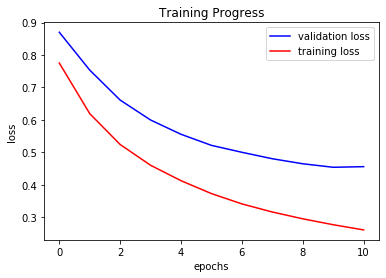

In [457]:
plt.title('Training Progress')
sub_axix = np.arange(len(dev_loss))
plt.plot(sub_axix, dev_loss, color='blue', label='validation loss')
plt.plot(sub_axix, loss_tr, color='red', label='training loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [458]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)["prediction"]) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8288888888888889
Precision: 0.8328503121114483
Recall: 0.8288888888888888
F1-Score: 0.8279770929043626


### Discuss how did you choose model hyperparameters ? 

Try learning rate at 0.001 at first, then 0.0001 and 0.00001 etc. If 0.00001 is too large and 0.000001 too small, I'll try value from 0.000002 to 0.000009 one by one. Finally 0.000002 is appropriate for my model.
If the learning rate is too low, the model is prone to overfitting and would takes more epochs to converge(low learning rate needs more epochs). If the learning rate is too large, the loss value is easily oscillating.

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary.

In [459]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [460]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_to_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [528]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,hidden_dim=[], num_classes=3)

#replace W[0] with w_glove
W[0] = w_glove 
for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)
    
W, loss_tr, dev_loss = SGD(X_train, Y_train,
                            W,
                            X_dev=X_dev, 
                            Y_dev=Y_dev,
                            lr=0.000002, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)

Shape W0 (8931, 300)
Shape W1 (300, 3)
Epoch: 0| Training loss: 0.9647728017040555| Validation loss: 1.1179650279646334
Epoch: 1| Training loss: 0.7142270413572348| Validation loss: 0.8865777115070543
Epoch: 2| Training loss: 0.5870036489692724| Validation loss: 0.7706786622841932
Epoch: 3| Training loss: 0.5081444600465905| Validation loss: 0.6698648149093026
Epoch: 4| Training loss: 0.44750898176706394| Validation loss: 0.621339678242145
Epoch: 5| Training loss: 0.4121042890919926| Validation loss: 0.5930473139018743
Epoch: 6| Training loss: 0.36843310535506096| Validation loss: 0.546890662051361
Epoch: 7| Training loss: 0.34828726277030886| Validation loss: 0.5259808308495713
Epoch: 8| Training loss: 0.3265925753257265| Validation loss: 0.4747646593807956
Epoch: 9| Training loss: 0.3109060333265159| Validation loss: 0.4690501756653546
Epoch: 10| Training loss: 0.29147388726905354| Validation loss: 0.4596863379544453
Epoch: 11| Training loss: 0.27343871330793934| Validation loss: 0.4

In [529]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)["prediction"]) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8344444444444444
Precision: 0.8378544596032637
Recall: 0.8344444444444444
F1-Score: 0.8346152833715023


### Discuss how did you choose model hyperparameters ? 

Try learning rate at 0.001 at first, then 0.0001 and 0.00001 etc. If 0.00001 is too large and 0.000001 too small, I'll try value from 0.000002 to 0.000009 one by one. Finally 0.000002 is appropriate for my model.
If the learning rate is too low, the model is prone to overfitting and would takes more epochs to converge(low learning rate needs more epochs). If the learning rate is too large, the loss value is easily oscillating.

# Extend to support deeper architectures (Bonus)

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. 

In [530]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)["prediction"]) for x,y in zip(X_test,Y_test)]
print('Accuracy:', accuracy_score(Y_test,preds_te))
print('Precision:', precision_score(Y_test,preds_te,average='macro'))
print('Recall:', recall_score(Y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test,preds_te,average='macro'))

Accuracy: 0.8344444444444444
Precision: 0.8378544596032637
Recall: 0.8344444444444444
F1-Score: 0.8346152833715023


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.833  | 0.829  | 0.828  | 0.829  |
| Average Embedding (Pre-trained)  | 0.838  | 0.834  | 0.835  | 0.834  |
| Average Embedding (Pre-trained) + X hidden layers (BONUS)   |   |   |   |   |
